# Loads the processed h5 file and plots data
### the minimalist way (using analysis.py)

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import sys

sys.path.insert(0, '../src/')
from data_analysis import *
from integrators import *
from analysis import *

In [2]:
# input parameters
run = '0069_droplets_10um_2mm'

# constants
detector_distance = 0.12 # m
energy = 9.5 # keV

# hit finders parameters
iq_thr = 0.12 # photon/pix/i0
r_min, r_max = 20,30 # bins

# ice finder parameters
filter_length = 5
ice_thr = 0.1 # delta photon/pix/i0
q_min, q_max = 1.0,4.5 # A-1

### load  and analyse data

In [3]:
# load data
img,Iq,r,nshots,i0,laser_i0,laser_on,event_ID = load_processed_data(run)

# convert q_scale
q = q_scale(r,detector_distance=detector_distance,photon_energy=energy*1000)

# convert intensity to photon/pix
img/=energy
Iq /=energy
i0 /=energy

# normalise to i0
Iq_norm = np.zeros(Iq.shape)
i0_avg = np.average(i0)
norm = i0/i0_avg
for i in range(int(nshots)):
    Iq_norm[i]=Iq[i]/norm[i]
    
# find hits
metric,hits = find_hits(Iq_norm,threshold=iq_thr)
#misses = np.logical_not(hits) & (i0[:nshots] > i0_avg - i0[:nshots].std()) # remove weak x-ray shots
#hits = hits & (i0[:nshots] > i0_avg - i0[:nshots].std()) # remove weak x-ray shots
hit_rate = np.sum(hits)/nshots


'''
# find ice hits
ice_metric,ice_hits = find_ice(Iq_norm[hits],q,threshold=ice_thr,filter_length=filter_length,q_min=q_min,q_max=q_max)
water_hits = hits.copy()
l = laser_i0[laser_on][:nshots]
laser_outliers = laser_on & ((laser_i0 > (l.mean() + l.std())) | (laser_i0 < (l.mean() - l.std())))
# find water hits
water_hits[hits] = water_hits[hits] & ~ice_hits & ~laser_outliers[hits] # remove ice shots and laser i0 outliers
if ice_hits.sum():
    print('found %d hits with >%.3f photon/pix (including %d ice hits)' % (hits.sum(), i0_avg*iq_thr, ice_hits.sum()))
else:
    print('found %d hits with >%.3f photon/pix' % (hits.sum(), i0_avg*iq_thr))

'''

# pump probe signal
#hit_avg,miss_avg,diff_signal =  pump_probe_signal(Iq,water_hits,laser_on,misses=misses,r_min=r_min,r_max=r_max)
hit_avg,miss_avg,diff_signal =  pump_probe_signal(Iq,hits,laser_on,misses=None,r_min=r_min,r_max=r_max)

run0069_droplets_10um_2mm: 18000 shots


### plot

<IPython.core.display.Javascript object>


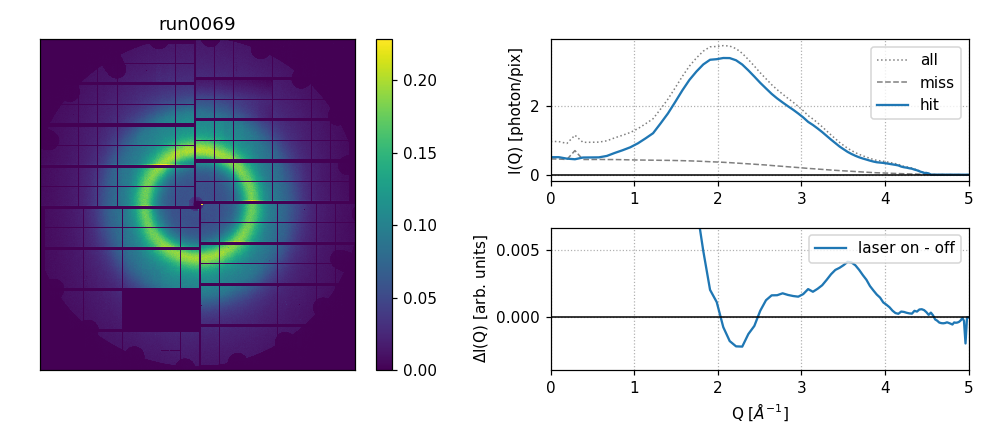

In [4]:
plt.figure(figsize=[9,4])

# 2d image
plt.subplot(1,2,1)
plt.title('run%s'%run[:4])
#plt.imshow(img/nshots,clim=[0,0.2],origin='lower')
i = (img/nshots)
plt.imshow(i,clim=[0,i.mean()+4*i.std()],origin='lower')
plt.colorbar()
plt.xticks([],'')
plt.yticks([],'')
plt.tight_layout()

# radial profile
plt.subplot(2,2,2)
#plt.title('water hitrate: %.1f%% (%d water hits)'%(100*water_hits.sum()/float(nshots), water_hits.sum()))
plt.plot(q, hit_avg,':',c='gray' ,lw=1,label='all')
plt.plot(q, miss_avg,'--',c='gray' ,lw=1,label='miss')
plt.plot(q, hit_avg - miss_avg, label='hit')
plt.ylabel('I(Q) [photon/pix]')
plt.legend(loc='upper right')
plt.axhline(0,c='black',lw=1)
plt.xlim(0,5)
plt.grid(linestyle='dotted')

# pump probe signal
ax = plt.subplot(2,2,4)
ax.plot(q, diff_signal, label='laser on - off')
plt.ylabel('$\Delta$I(Q) [arb. units]')
#plt.ylim([-1,1]) #plt.figure()
s = diff_signal[20:40]
plt.ylim([s.min()-s.std(), s.max()+s.std()])
plt.xlabel('Q [$\AA^{-1}$]')
plt.legend(loc='upper right')
plt.xlim(0,5)
plt.axhline(0,c='black',lw=1)
plt.grid(linestyle='dotted')

plt.tight_layout()
plt.savefig('run%s_diff_signal.png' % run)
plt.show()


<IPython.core.display.Javascript object>


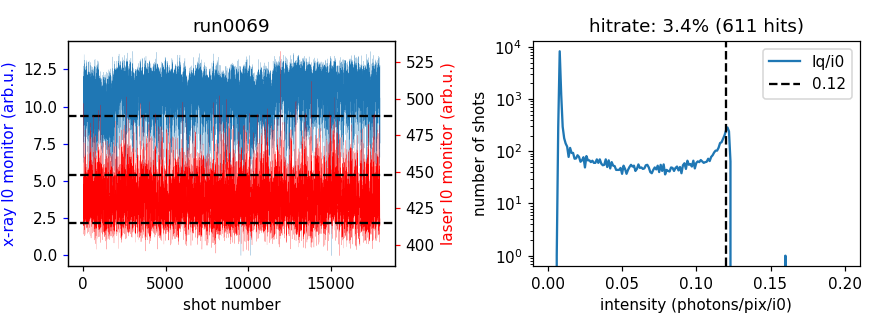

In [14]:
plt.figure(figsize=[8,3])

# i0 monitor
ax1 = plt.subplot(1,2,1)
plt.title('run%s'%run[:4])
ax1.plot(i0[:int(nshots)],lw=.1)
ax1.set_ylabel('x-ray I0 monitor (arb.u.)',color='b')
ax1.set_xlabel('shot number')
ax1.tick_params('y',color='b')
m = i0[:int(nshots)].mean()
s = i0[:int(nshots)].std()
#ax1.axhline(y=(m+1*s),c='black',ls='--')
ax1.axhline(y=(m-1*s),c='black',ls='--')

ax2 = ax1.twinx()
ax2.plot(np.arange(len(laser_i0))[laser_on.astype(np.bool)],laser_i0[laser_on.astype(np.bool)][:int(nshots)],lw=.1,color='r')
ax2.set_ylabel('laser I0 monitor (arb.u.)',color='r')
ax2.tick_params('y',color='r')
m = laser_i0[laser_on.astype(np.bool)][:int(nshots)].mean()
s = laser_i0[laser_on.astype(np.bool)][:int(nshots)].std()
ax2.axhline(y=(m+1*s),c='black',ls='--')
ax2.axhline(y=(m-1*s),c='black',ls='--')

# hit estimator
plt.subplot(1,2,2)
x,y = do_histogram(metric,0,0.2,.001)
plt.plot(x,y)
plt.axvline(x=iq_thr,c='black',ls='--')
plt.legend(['Iq/i0',iq_thr])
plt.ylabel('number of shots')
plt.yscale('log',nonposy='clip')
plt.xlabel('intensity (photons/pix/i0)')
plt.title('hitrate: %.1f%% (%d hits)'%(100*hit_rate, hits.sum()))

plt.tight_layout()
plt.savefig('run%s_shot_statistics.png' % run)
plt.show()

In [39]:
# hexagonal ice peaks
HIceQ = {'100':1.611, '002':1.717, '101':1.848, '102':2.353, '110':2.793, '103':3.035, '200':3.222, '112':3.272, '201':3.324}
HIcePos = {'100':10.5, '002':9.5, '101':8.5, '102':6.2, '110':6.2, '103':6.2, '200':7., '112':6., '201':5.}
HIceQLabel = {'100':1.611, '002':1.717, '101':1.848, '102':2.353, '110':2.793, '103':3.035, '200':3.324, '112':3.374, '201':3.426}
HIceP = {'100':9.5, '002':8.5, '101':7.5, '102':7.5, '110':7.5, '103':7.5, '200':7., '112':5., '201':3.}
numQLabels = len(HIceQ.keys())+1
# ice shots
ice_hits = ice_hits & (i0 > i0_avg - i0.std())[hits]
if (ice_hits.sum() > 0):
    plt.figure(figsize=[9,3])
    plt.subplot2grid((1,3),(0,0),colspan=2)
    n = 0
    for i in Iq_norm[hits][ice_hits]:
        if laser_on[hits][ice_hits][n]:
            l = "%d: laser on" % (n+1)
        else:
            l = "%d: laser off" % (n+1)
        plt.plot(q,i*i0_avg,label=l)
        n += 1
        if n > 7:
            break
    plt.plot(q,np.average(Iq_norm[hits][ice_hits], axis=0)*i0_avg,color='black',label='mean')
    plt.ylabel('I(Q) [photon/pix]')
    plt.xlabel('Q [$\AA^{-1}$]')
    plt.legend(loc='upper left')
    plt.title('run%s'%(run[:4]))
    for i,j in HIceQ.items():
        labelPosition = HIceP[i]*np.max(Iq[hits][ice_hits])/numQLabels
        plt.axvline(x=j, color='k', ls='--')
        plt.text(HIceQ[i], labelPosition, str(i), rotation="45")
    
    # hit estimator
    plt.subplot2grid((1,3),(0,2))
    x,y = do_histogram(ice_metric,0,ice_metric[ice_metric < 1].max(),.01)
    plt.plot(x,y)
    plt.axvline(x=ice_thr,c='black',ls='--')
    plt.legend(['Iq/i0',ice_thr])
    plt.ylabel('number of shots')
    plt.yscale('log',nonposy='clip')
    plt.xlabel('$\Delta$I (photons/pix/i0)')
    plt.title('icerate: %.2f%% (%d ice hits)' % (100*ice_hits.sum()/float(hits.sum()), ice_hits.sum()))

    plt.tight_layout()
    plt.savefig('run%s_ice_shots.png' % run)
    plt.show()